# Peptide Identification Pipeline using Custom Database

In this project, we aim to develop an algorithm that identifies the microbial composition of a mass spectrometry (MS) sample based on de novo peptide sequencing data. 
Using the predicted peptides, we reconstruct a custom protein sequence database that is optimized for the specific microbial community in the sample.

The pipeline involves several key steps:
- Filtering the de novo peptides based on Average Local Confidence (ALC) scores to retain only high-confidence sequences.
- Cleaning peptide sequences to remove post-translational modification notations.
- Determining the taxonomic origin of peptides by querying UniProt in batch mode.
- Building the microbial community composition based on the taxonomy assignments.
- Constructing a targeted protein database by collecting protein sequences from the identified taxa.
- Reducing database redundancy through clustering to optimize search efficiency and minimize false positives.

By tailoring the database to the actual community composition, we aim to achieve more accurate protein identifications in metaproteomic studies — approaching the performance of genome-based identification strategies, without the need for extensive metagenomic sequencing.

As a first step, we will filter the de novo sequencing results to retain only high-confidence peptides with an Average Local Confidence (ALC) score greater than 70%.

In [4]:
# Import necessary libraries
import pandas as pd

# Load the de novo peptide data
file_path = "de_novo_garmerwolde.csv"
df = pd.read_csv(file_path)  

# Display the dataset dimensions
print(f"Original dataset shape: {df.shape}")

# Display rows 24219 to 24227 (Python is zero-indexed → use iloc[24218:24227+1])
print("Original Data (rows 24219–24227):")
display(df.iloc[24218:24228])

# Filter peptides with ALC (%) > 70
filtered_df = df[df["ALC (%)"] > 70]

# Display the filtered dataset dimensions
print(f"Filtered dataset shape: {filtered_df.shape}")

# Display same rows (if they exist after filtering — some will be removed)
print("Filtered Data (rows 24219-24227):")
display(filtered_df.iloc[24218:24228])  # This only works if enough rows remain after filtering
print(f"Number of peptides filtered out: {df.shape[0] - filtered_df.shape[0]}")

Original dataset shape: (189185, 20)
Original Data (rows 24219–24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
24218,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,KYAYFPVWVNDDKMSLPLR,F2:51275,19,76,68,19,781.3988,3,143.42,142.11,0.0,2341.1929,-7.8,NaN,45 39 41 35 33 43 89 98 98 94 95 96 94 90 83 4...,KYAYFPVWVNDDKMSLPLR,HCD
24219,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:35083,MWALDLR,F1:38190,7,76,78,7,452.7394,2,113.16,129.39,34588.0,903.4636,0.6,NaN,56 71 84 79 79 85 90,MWALDLR,HCD
24220,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:98838,LAAALTPAPVLAK,F2:33083,13,76,70,13,618.3896,2,100.95,110.95,13217000.0,1234.7649,-0.2,NaN,48 50 80 99 100 100 99 96 33 31 48 45 82,LAAALTPAPVLAK,HCD
24221,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:83383,APMSGLQNWK,F2:29687,10,76,70,10,566.2845,2,92.40,83.12,214530.0,1130.5542,0.3,NaN,96 94 85 92 82 41 28 21 69 92,APMSGLQNWK,HCD
24222,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:107262,SLTAPSGVPGM(+15.99)FK,F2:26077,13,76,67,13,654.3237,2,83.51,83.66,75731.0,1306.6592,-20.1,Oxidation (M),37 46 79 93 95 96 88 84 23 17 26 89 97,SLTAPSGVPGM(+15.99)FK,HCD
24223,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:139236,EVQAWSWWWM(+15.99)TRRAAMDVPGR,F2:49588,21,76,68,21,879.0955,3,139.45,141.68,822420.0,2634.2371,10.4,Oxidation (M),37 25 33 44 44 41 81 84 90 88 90 40 52 96 95 8...,EVQAWSWWWM(+15.99)TRRAAMDVPGR,HCD
24224,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:3957,MGFYGGR,F2:13573,7,76,68,7,394.1815,2,50.45,47.75,376120.0,786.3483,0.3,NaN,17 29 90 86 80 83 90,MGFYGGR,HCD
24225,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:103943,TLGALDGTN(+.98)MNR,F1:23486,12,76,71,12,632.3035,2,78.32,67.85,3662600.0,1262.5925,0.0,Deamidation (NQ),21 21 26 76 99 98 90 88 70 82 91 93,TLGALDGTN(+.98)MNR,HCD
24226,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:23734,LGGLSSAMK,F1:16822,9,76,75,9,432.2354,2,59.98,63.31,416090.0,862.4582,-2.4,NaN,62 77 48 88 82 73 68 78 97,LGGLSSAMK,HCD
24227,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LDQ(+.98)AHLYNWQWYR,F2:50574,13,76,77,13,897.4365,2,141.76,127.60,0.0,1792.8320,14.8,Deamidation (NQ),31 38 40 61 54 99 98 96 96 94 95 98 100,LDQ(+.98)AHLYNWQWYR,HCD


Filtered dataset shape: (32111, 20)
Filtered Data (rows 24219-24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
25984,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LVTTDANGWYNK,F2:16205,12,75,73,12,691.3395,2,57.63,71.80,0.0,1380.6675,-2.1,NaN,59 60 95 95 95 89 83 70 69 28 43 98,LVTTDANGWYNK,HCD
25985,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:39500,KATSLMDR,F2:7950,8,75,76,8,461.2376,2,32.97,17.78,841190.0,920.4749,-15.5,NaN,77 34 38 87 93 88 96 94,KATSLMDR,HCD
25986,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:103841,WAADLDQ(+.98)MVTK,F2:42699,11,75,75,11,639.8031,2,123.18,107.95,109590.0,1277.5962,-3.6,Deamidation (NQ),78 60 90 90 89 94 89 69 28 41 98,WAADLDQ(+.98)MVTK,HCD
25989,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:18876,Q(+.98)VYLHMDGFR,F1:35026,10,75,72,10,422.8690,3,105.90,95.37,299660.0,1265.5862,-0.9,Deamidation (NQ),26 28 45 61 92 95 98 92 94 96,Q(+.98)VYLHMDGFR,HCD
25990,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:113009,TLLPALYLLQGR,F2:54646,12,75,74,12,679.4126,2,151.38,164.41,25185.0,1356.8130,-1.7,NaN,51 50 50 33 82 89 93 95 85 79 88 98,TLLPALYLLQGR,HCD
25991,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:139595,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,F1:54391,22,75,72,22,847.3984,3,151.74,161.24,6012700.0,2539.1841,-4.2,Deamidation (NQ); Carbamidomethylation,49 40 57 62 82 96 69 44 92 49 28 34 96 97 97 8...,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,HCD
25993,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,-,YHDALTYVWNWGGFTGK,F1:45457,17,75,85,17,1007.9756,2,130.26,163.81,0.0,2013.9373,-0.3,NaN,34 20 62 78 99 99 98 98 98 97 98 97 97 98 98 9...,YHDALTYVWNWGGFTGK,HCD
25994,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:852,NSLAVLR,F1:12592,7,75,81,7,386.7372,2,48.50,66.00,1484500.0,771.4603,-0.4,NaN,61 60 82 92 94 94 86,NSLAVLR,HCD
25995,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:141090,NYLDDLR,F2:41876,7,75,85,7,908.4518,1,121.32,83.38,208150.0,907.4399,5.0,NaN,85 83 85 82 85 88 90,NYLDDLR,HCD
25997,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:129117,YM(+15.99)APQEVGPGSPFR,F2:34615,14,75,78,14,776.3701,2,104.14,93.71,57385.0,1550.7188,4.5,Oxidation (M),37 35 43 41 90 96 95 97 93 92 94 82 95 100,YM(+15.99)APQEVGPGSPFR,HCD


Number of peptides filtered out: 157074


In [5]:
# Define the wrangle_peptides function
import re

def wrangle_peptides(sequence: str, ptm_filter: bool=True, li_swap: bool=True) -> str:
    """Process peptide sequences by removing post-translational modifications
    and/or equating Leucine and Isoleucine amino acids.

    Args:
        sequence (str): Peptide sequence string
        ptm_filter (bool, optional): Remove PTMs from sequence. Defaults to True.
        li_swap (bool, optional): Equate Leucine (L) and Isoleucine (I). Defaults to True.

    Returns:
        str: Processed sequence string
    """
    if ptm_filter:
        sequence = "".join(re.findall(r"[A-Z]+", sequence))
    if li_swap:
        sequence = sequence.replace("L", "I")
    return sequence

# Apply wrangle_peptides function to the filtered data
filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))

# Display rows 11 to 21 (Python is 0-indexed, so need 10:21)
print("Cleaned Peptides (Rows 11–21):")
display(filtered_df[["Peptide", "Cleaned Sequence"]].iloc[10:21])


Cleaned Peptides (Rows 11–21):


C:\Users\yusuf\AppData\Local\Temp\ipykernel_29900\2530972787.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))


,Peptide,Cleaned Sequence
10,TSLLN(+.98)YLR,TSIINYIR
11,VVQLTMQ(+.98)TQEK,VVQITMQTQEK
12,ATMSDFSPK,ATMSDFSPK
13,LSELTSLTSAPR,ISEITSITSAPR
14,VSQ(+.98)AVLAASSGR,VSQAVIAASSGR
15,VGLAWDR,VGIAWDR
16,YLPASC(+57.02)R,YIPASCR
17,ASVEDLLK,ASVEDIIK
18,YPDVATTHGGSATK,YPDVATTHGGSATK
19,VMGVAFN(+.98)R,VMGVAFNR


In [6]:
# Import necessary libraries
import requests

# Define the fetch_request function
def fetch_request(url: str, retries: int = 3, delay: int = 5) -> requests.Response:
    """Send GET request and return response object. Retries if server error encountered.

    Args:
        url (str): input URL.
        retries (int, optional): Number of retry attempts. Defaults to 3.
        delay (int, optional): Seconds to wait between retries. Defaults to 5 seconds.

    Raises:
        RuntimeError: If request fails after all retries.

    Returns:
        requests.Response: Response object
    """
    import time
    for attempt in range(retries):
        req_get = requests.get(url)
        
        if req_get.status_code == 200:
            return req_get  # Success!

        print(f"Request failed with status {req_get.status_code}. Retrying ({attempt+1}/{retries}) in {delay} seconds...")
        time.sleep(delay)
    
    error_msg = f"Request failed after {retries} retries: statuscode {req_get.status_code}"
    raise RuntimeError(error_msg)

In [7]:
# Define the request_unipept_pept_to_lca function
def request_unipept_pept_to_lca(pept_df: pd.DataFrame, seq_col: str) -> pd.DataFrame:
    """From a dataset of peptides, fetch LCA taxonomy and rank from UniPept database.

    Args:
        pept_df (pd.DataFrame): Peptide dataset.
        seq_col (str): Column with peptide sequences.

    Returns:
        pd.DataFrame: Peptide sequences with LCA taxonomy and LCA rank.
    """
    # Base URL for the UniPept pept2lca API with equate_il=true (I and L treated as equal)
    base_url = "http://api.unipept.ugent.be/api/v1/pept2lca.json?equate_il=true"

    # Number of peptides to include per API request (due to API limits)
    batch_size = 100

    # Create a list of unique peptide strings in the correct API format: '&input[]=PEPTIDE'
    seq_series = ["&input[]=" + seq for seq in pept_df[seq_col].drop_duplicates()]

    # Initialize an empty DataFrame to collect all LCA results
    lca_df = pd.DataFrame(columns=[seq_col, "Global LCA", "Global LCA Rank"], dtype=object)

    print(f"🔢 Total batches: {len(seq_series) // batch_size + (1 if len(seq_series) % batch_size else 0)}")

    # x is the index for batching through seq_series
    x = 0
    while True:
        # Get the next batch of peptides for the current request
        if x + batch_size >= len(seq_series):
            peptides = seq_series[x:]  # Last batch (may be smaller than batch_size)
        else:
            peptides = seq_series[x:x+batch_size]  # Normal batch of size 100

        # Concatenate the base URL with the batch of peptides to form the full request string
        req_str = "".join([base_url, *peptides])

        # Send the HTTP request and parse the JSON response
        response = fetch_request(req_str).json()

        # Convert each item in the response into a row in the DataFrame
        # Use .get() with default value "Unknown" in case a field is missing
        lca_df = pd.concat([
            lca_df,
            pd.DataFrame(
                [
                    (
                        elem.get("peptide", "Unknown"),     # peptide sequence
                        elem.get("taxon_id", "Unknown"),    # taxon ID (LCA)
                        elem.get("taxon_rank", "Unknown")   # taxonomic rank of LCA
                    )
                    for elem in response
                ],
                columns=[seq_col, "Global LCA", "Global LCA Rank"]
            )
        ])

        # Move the index forward by the batch size
        x += batch_size

        # Break the loop when all peptides have been processed
        if x >= len(seq_series):
            break

    # Return the full DataFrame with LCA results for all input peptides
    return lca_df

In [7]:
# Now run the function on our cleaned peptide dataset
# We pass filtered_df with the 'Cleaned Sequence' column

print("Fetching taxonomy information from UniPept...")
lca_results_df = request_unipept_pept_to_lca(filtered_df, seq_col="Cleaned Sequence")

# Display the first few results
print("LCA Mapping Results:")
display(lca_results_df.head())

Fetching taxonomy information from UniPept...
🔢 Total batches: 265
LCA Mapping Results:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
2,ITGMAFR,1,no rank
3,IGSDAYNQK,3379134,kingdom
4,IGATYDIFGDGK,1,no rank


In [6]:
# Display the lca dataset dimensions
print(f"LCA results dataset shape: {lca_results_df.shape}")

LCA results dataset shape: (8703, 3)


Now that we have obtained the taxonomic assignments for our peptides in the lca_results_df dataset, we want to examine how many peptides were classified at each taxonomic rank (e.g., species, genus, family).
This helps us evaluate the overall resolution of our data and determine which rank is most appropriate for downstream analysis and visualization of the microbial community composition.

In [7]:
# Count the number of peptides per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Display the counts
print("Peptide counts per LCA rank:")
display(rank_counts)

Peptide counts per LCA rank:


Global LCA Rank
no rank          6610
species           824
domain            356
genus             268
class             142
strain            126
phylum            115
kingdom           109
family             61
order              36
subphylum          10
subfamily           8
subclass            7
subkingdom          6
subspecies          5
subgenus            5
infraorder          5
superclass          4
species group       3
suborder            1
tribe               1
varietas            1
Name: count, dtype: int64

In [8]:
# This code allows us to automatically define the allowed_ranks based on the frequency of occurrence in the dataset.
# Step 1: Replace 'no rank' with 'Unclassified' for clarity
lca_results_df["Global LCA Rank"] = lca_results_df["Global LCA Rank"].replace("no rank", "Unclassified")

# Step 2: Count how many peptides exist per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Step 3: Define canonical rank order (from general to specific)
canonical_rank_order = [
    "domain", "kingdom", "subkingdom", "superclass", "phylum", "subphylum",
    "class", "subclass", "order", "suborder", "infraorder", "family", "subfamily",
    "genus", "subgenus", "species group", "species", "subspecies",
    "strain", "varietas", "tribe"
]

# Step 4: Filter canonical ranks based on frequency threshold
rank_frequency_cutoff = 15
allowed_ranks = [rank for rank in canonical_rank_order if rank_counts.get(rank, 0) >= rank_frequency_cutoff]

# Step 5: Print the allowed ranks to verify order and contents
print("Allowed ranks based on cutoff and specificity:")
print(allowed_ranks)

# Step 6: Filter the DataFrame to only include allowed ranks
filtered_lca_df = lca_results_df[lca_results_df["Global LCA Rank"].isin(allowed_ranks)].copy()

# Step 7: Count how many times each taxon ID appears
taxon_counts = filtered_lca_df["Global LCA"].value_counts()

# Step 8: Apply a frequency cutoff (e.g. at least 10 peptides per taxon ID)
taxa_to_keep = taxon_counts[taxon_counts >= 10].index

# Step 9: Keep only rows with a frequently occurring taxon ID
filtered_lca_df = filtered_lca_df[filtered_lca_df["Global LCA"].isin(taxa_to_keep)]

# Summary printout
print(f"\nFiltered dataset shape: {filtered_lca_df.shape}")
print("Preview of filtered dataset:")
display(filtered_lca_df.head())


Allowed ranks based on cutoff and specificity:
['domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']

Filtered dataset shape: (1005, 3)
Preview of filtered dataset:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
3,IGSDAYNQK,3379134,kingdom
6,ISAVGEVYDIK,1400863,strain
8,ATMSDFSPK,327160,species


In [9]:
# Some test code to check if the scientific name is present in the response
taxon_id = 1234
url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
params = {
    "db": "taxonomy",
    "id": taxon_id,
    "retmode": "json"
}

response = requests.get(url, params=params)
print("Status code:", response.status_code)
print(response.json())  # <- This should contain 'scientificname'


Status code: 200
{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1234'], '1234': {'uid': '1234', 'status': 'active', 'rank': 'genus', 'division': 'bacteria', 'scientificname': 'Nitrospira', 'commonname': '', 'taxid': 1234, 'akataxid': '', 'genus': '', 'species': '', 'subsp': '', 'modificationdate': '2015/08/12 00:00', 'genbankdivision': 'Bacteria'}}}


In [10]:
import requests
import time

# Step 1: Get unique taxon IDs from the filtered dataframe
unique_taxa = filtered_lca_df["Global LCA"].unique()

# Step 2: Define a dictionary to store Taxon ID → Scientific Name
taxon_to_name = {}

# Step 3: Query NCBI Entrez API for each taxon ID
for taxon_id in unique_taxa:
    try:
        url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
        params = {
            "db": "taxonomy",
            "id": taxon_id,
            "retmode": "json"
        }

        response = requests.get(url, params=params)
        data = response.json()
        
        result = data.get("result", {})
        if str(taxon_id) in result:
            sci_name = result[str(taxon_id)].get("scientificname", "Unknown")
            taxon_to_name[taxon_id] = sci_name
        else:
            taxon_to_name[taxon_id] = "Unknown"
    
    except Exception as e:
        taxon_to_name[taxon_id] = "Error"
    
    time.sleep(0.2)  # Be kind to the API

# Step 4: Map scientific names back into a new dataframe
filtered_lca_named_df = filtered_lca_df.copy()
filtered_lca_named_df["Scientific Name"] = filtered_lca_named_df["Global LCA"].map(taxon_to_name)

# Step 5: Preview the new dataframe
print("Preview of dataframe with scientific names:")
display(filtered_lca_named_df)


Preview of dataframe with scientific names:


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name
0,AISTWFTIK,1234,genus,Nitrospira
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter
3,IGSDAYNQK,3379134,kingdom,Pseudomonadati
6,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11
8,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis
...,...,...,...,...
16,FAAACQQK,2,domain,Bacteria
25,FIEISWPK,2759,domain,Eukaryota
28,GNSDVGFR,2759,domain,Eukaryota
16,ASVIFMPK,2759,domain,Eukaryota


In [11]:
import xml.etree.ElementTree as ET

# Step 1: Get unique taxon IDs from your DataFrame
taxon_ids = filtered_lca_named_df["Global LCA"].dropna().unique()

# Step 2: Create an empty dictionary to store taxon ID → lineage mapping
taxon_lineages = {}

# Step 3: Function to fetch lineage from NCBI Entrez
def fetch_lineage(taxon_id):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "taxonomy",
        "id": str(taxon_id),
        "retmode": "xml"
    }

    try:
        response = requests.get(url, params=params)
        root = ET.fromstring(response.content)
        lineage_dict = {}
        for taxon in root.findall(".//Taxon"):
            rank = taxon.find("Rank")
            name = taxon.find("ScientificName")
            if rank is not None and name is not None and rank.text != "no rank":
                lineage_dict[rank.text.lower()] = name.text
        return lineage_dict
    except Exception as e:
        print(f"Error with taxon ID {taxon_id}: {e}")
        return {}

# Step 4: Loop through all taxon IDs and build the dictionary
for tid in taxon_ids:
    taxon_lineages[tid] = fetch_lineage(tid)
    time.sleep(0.3)  # to avoid overwhelming the server

# Optional: Display the result as a table
import pandas as pd
lineage_df = pd.DataFrame.from_dict(taxon_lineages, orient="index").fillna("NA")
display(lineage_df.head())


,genus,cellular root,domain,kingdom,phylum,class,order,family,strain,species,clade
1234,Nitrospira,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,NA,NA,NA
327159,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,NA,NA,NA,NA,NA
1400863,Candidatus Competibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,NA,Candidatus Competibacteraceae,Candidatus Competibacter denitrificans Run_A_D11,Candidatus Competibacter denitrificans,NA
327160,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,NA,NA,NA,Candidatus Accumulibacter phosphatis,NA
330214,Nitrospira,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,NA,Nitrospira defluvii,NA


In [12]:
print(filtered_lca_named_df.shape)
print(lineage_df.shape)
print(len(taxon_ids)) # it seems that the majority of the taxon IDs are duplicates of each other

(1005, 4)
(22, 11)
22


In [13]:
lineage_df = lineage_df.reset_index().rename(columns={"index": "Global LCA"})
merged_df = filtered_lca_named_df.merge(lineage_df, on="Global LCA", how="left")
print(merged_df.shape)
display(merged_df.head())

(1005, 15)


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name,genus,cellular root,domain,kingdom,phylum,class,order,family,strain,species,clade
0,AISTWFTIK,1234,genus,Nitrospira,Nitrospira,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,NA,NA,NA
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,NA,NA,NA,NA,NA
2,IGSDAYNQK,3379134,kingdom,Pseudomonadati,NA,cellular organisms,Bacteria,Pseudomonadati,NA,NA,NA,NA,NA,NA,NA
3,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11,Candidatus Competibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,NA,Candidatus Competibacteraceae,Candidatus Competibacter denitrificans Run_A_D11,Candidatus Competibacter denitrificans,NA
4,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,NA,NA,NA,Candidatus Accumulibacter phosphatis,NA


In [14]:
def assign_taxonomic_label(df: pd.DataFrame, target_rank: str) -> pd.Series:
    """
    Assigns each row in the DataFrame to a taxonomic label at the specified rank.

    If a peptide is annotated at or below the target rank, it will be assigned
    the label from that rank. If not, it will be labeled as 'Unclassified'.

    Parameters:
        df (pd.DataFrame): DataFrame containing taxonomic lineage columns.
        target_rank (str): The desired rank to group peptides by (e.g., 'phylum', 'kingdom').

    Returns:
        pd.Series: A column with assigned labels for each peptide at the given rank.
    """
    if target_rank not in df.columns:
        raise ValueError(f"Target rank '{target_rank}' not found in the dataframe columns.")
    
    return df[target_rank].fillna("Unclassified").replace("NA", "Unclassified")


In [15]:
# List of considered ranks (same as in your allowed_ranks + others you may want to evaluate)
ranks_to_check = allowed_ranks

# Dictionary to store results
rank_label_counts = {}

# Loop through each rank and count peptides per label
for target_rank in ranks_to_check:
    try:
        # Assign a label for the current rank
        labels = assign_taxonomic_label(merged_df, target_rank)
        
        # Count the number of peptides per label
        label_counts = labels.value_counts().sort_values(ascending=False)
        
        # Store the result
        rank_label_counts[target_rank] = label_counts
    except Exception as e:
        print(f"Error processing rank '{target_rank}': {e}")

In [16]:
# Display the counts for the phylum level as a test
print("Peptide counts at phylum level:")
display(rank_label_counts["phylum"])
 
print("Peptide counts at domain level:")
display(rank_label_counts["domain"])

Peptide counts at phylum level:


phylum
Pseudomonadota    464
Unclassified      462
Nitrospirota       46
Actinomycetota     23
Bacteroidota       10
Name: count, dtype: int64

Peptide counts at domain level:


domain
Bacteria     837
Eukaryota    168
Name: count, dtype: int64

An important remark to make: We do not consider the unclassified peptides outside of the domain level, as they are not informative for the analysis. This means that the majority of our peptides (6610 out of the total, which is 76%) are not used for determining the community composition. Since these "no rank" peptides could have been informative, if they were ranked, we cannot conclude our obtained community composition with certainty, since only 24% of the peptides are ranked and thus informative. Also, we cannot guarantee that all the possible peptides in our sample are actually analyzed in the MS. So, we might already miss some proteins during the LC-tandem mass spectrometry procedure, which means our csv dataset is not complete per definition.  

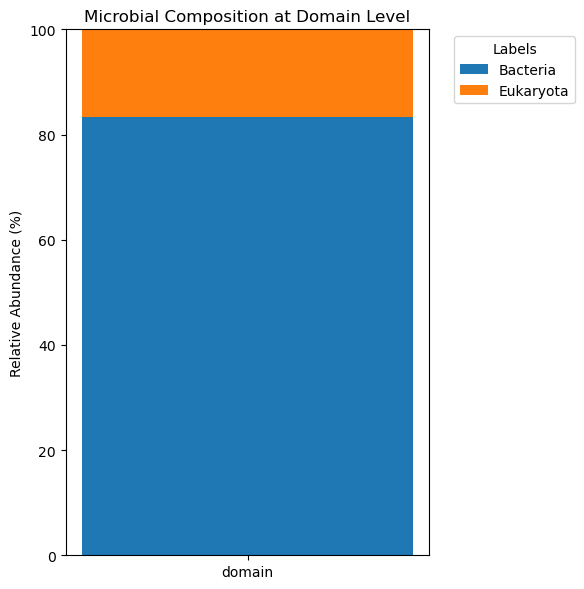

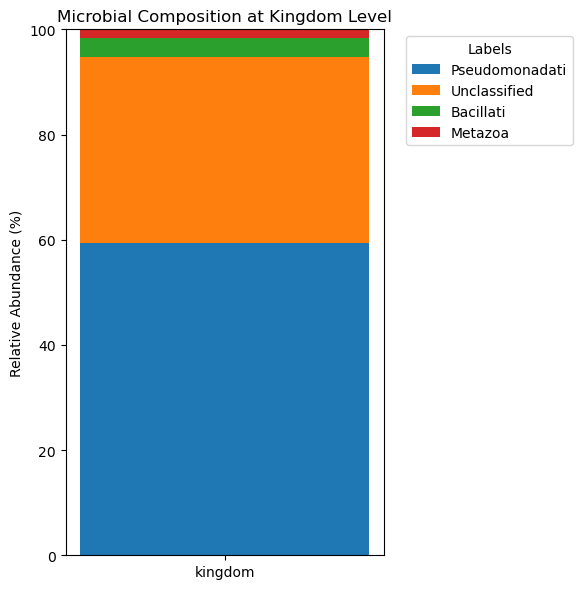

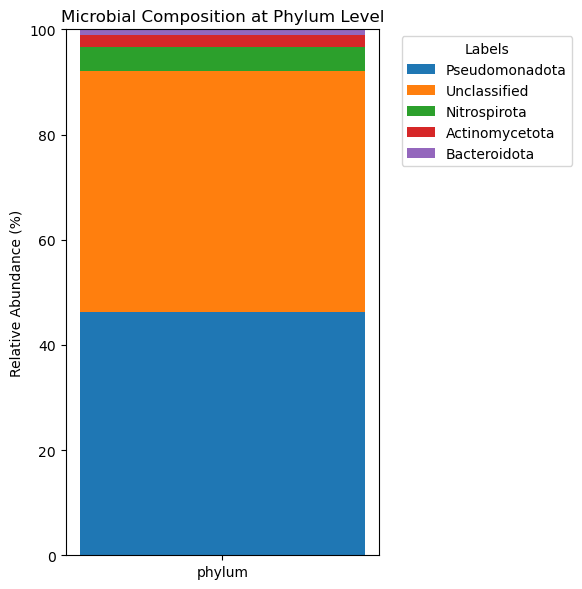

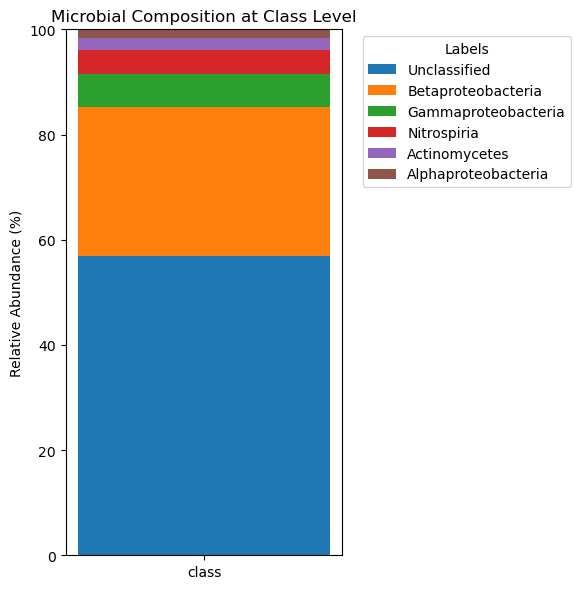

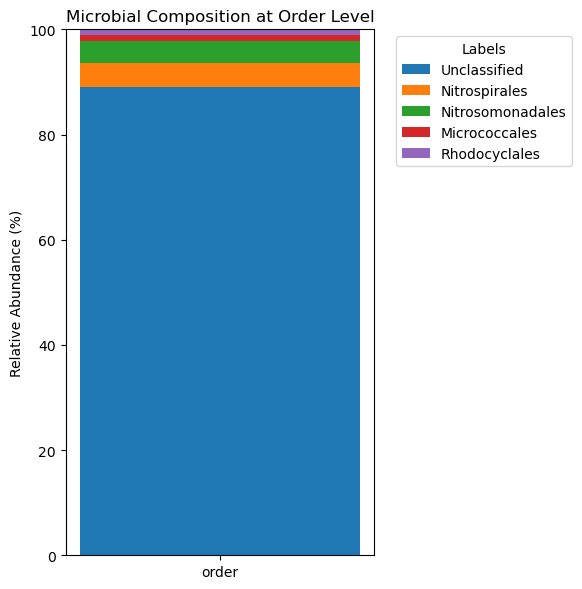

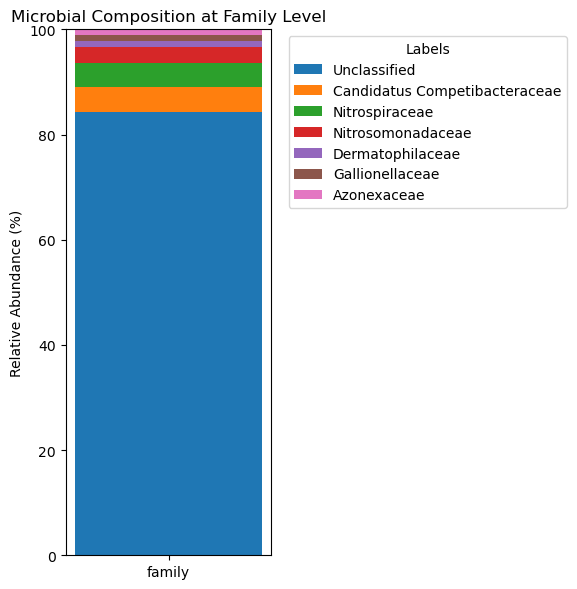

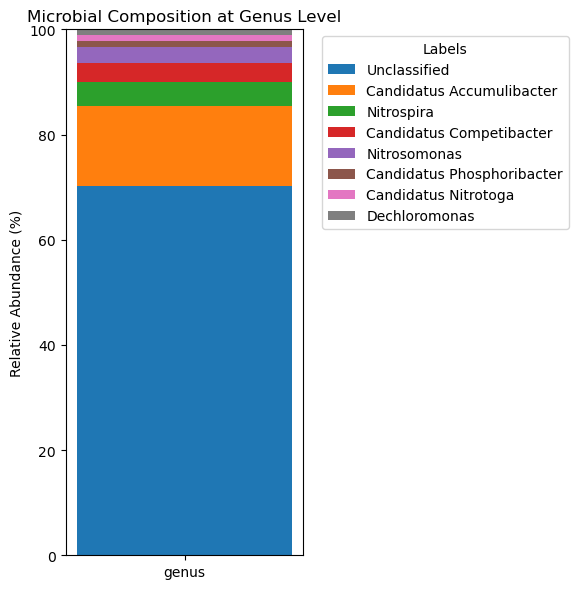

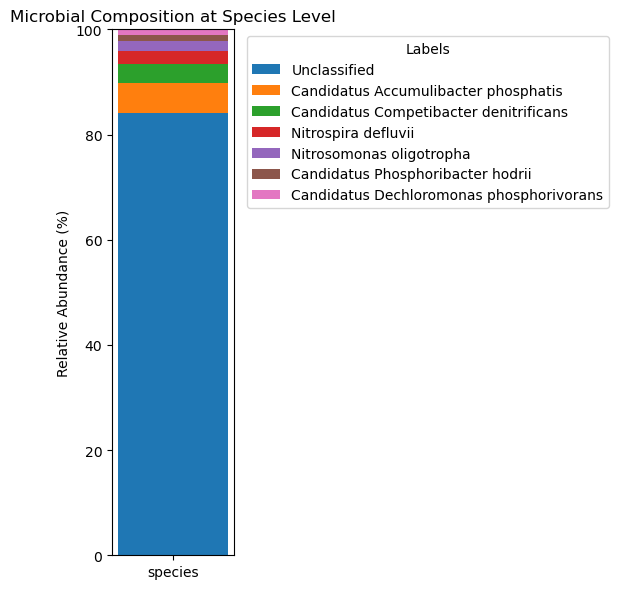

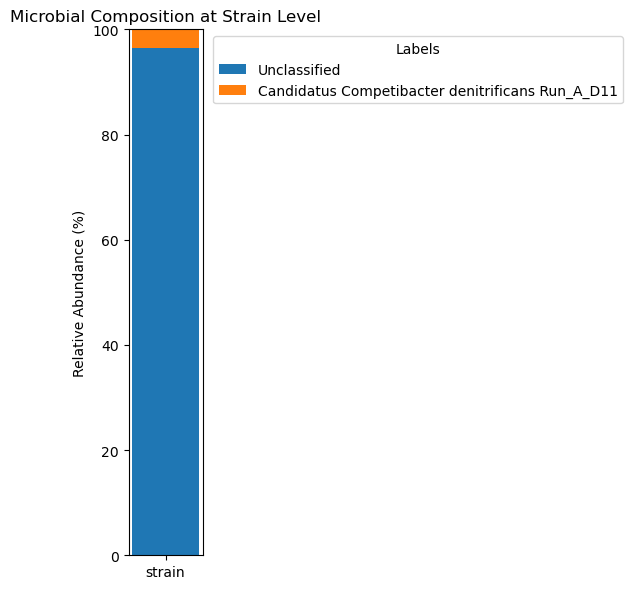

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Step: Loop through each rank and create a stacked bar chart
for rank, label_counts in rank_label_counts.items():
    # Convert the label counts (Series) to a DataFrame with percentages
    df = label_counts.reset_index()
    df.columns = ["Label", "Count"]
    df["Percent"] = df["Count"] / df["Count"].sum() * 100

    # Sort labels by abundance for consistent stacking
    df = df.sort_values(by="Percent", ascending=False)

    # Plot settings
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a single stacked bar for the current rank
    bottom = 0
    for _, row in df.iterrows():
        ax.bar(rank, row["Percent"], bottom=bottom, label=row["Label"])
        bottom += row["Percent"]

    # Final adjustments
    ax.set_title(f"Microbial Composition at {rank.capitalize()} Level")
    ax.set_ylabel("Relative Abundance (%)")
    ax.set_ylim(0, 100)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")

    plt.tight_layout()
    plt.show()

Now that we have identified our community composition at differnt rank levels, we want to create a custom database that contains only protein sequences from taxa that were confidently identified as most abundant in our sample. This is because we want to: maximize coverage of relevant proteins from the dominant community members, minimize false positives (FDR), because we exclude unrelated/unlikely taxa from global reference databases and speed up downstream database searching (smaller DB → faster and more accurate MS search)

In [18]:

# This script downloads FASTA sequences for the top taxa (most common Glocal LCA taxon IDs) in the filtered dataset, REGARDLESS OF RANK.
import os
from datetime import datetime

def download_uniprot_fasta_by_taxid(taxon_id, taxon_name, output_dir="fasta_proteomes", reviewed=True, max_entries=500):
    """
    Download protein FASTA sequences from UniProt using NCBI Taxon ID.
    Saves files in a session-specific folder.
    """
    os.makedirs(output_dir, exist_ok=True)
    reviewed_str = "reviewed:true" if reviewed else "reviewed:false"
    
    query = f'taxonomy_id:{taxon_id} AND {reviewed_str}'
    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={max_entries}"

    try:
        print(f"Fetching proteins for taxon: {taxon_name} (ID: {taxon_id})")
        response = requests.get(url)

        if response.status_code == 200 and response.text.strip():
            file_name = f"{taxon_name.replace(' ', '_')}_{taxon_id}.fasta"
            with open(os.path.join(output_dir, file_name), "w") as f:
                f.write(response.text)
            print(f"✅ Saved to {file_name}\n")
        else:
            print(f"❌ No proteins found (Status: {response.status_code})\n")
    except Exception as e:
        print(f"❌ Error for {taxon_name}: {e}")
        

# === Create new session folder ===
base_dir = "fasta_proteomes"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
session_dir = os.path.join(base_dir, f"session_{timestamp}")
os.makedirs(session_dir, exist_ok=True)
print(f"🔖 Created output folder: {session_dir}\n")

# === Get top taxa and names ===
top_taxa = filtered_lca_named_df["Global LCA"].value_counts().head(5).index.tolist()
taxon_id_to_name = filtered_lca_named_df.set_index("Global LCA")["Scientific Name"].to_dict()

for tid in top_taxa:
    name = taxon_id_to_name.get(tid, f"taxon_{tid}")
    if name != "Unclassified":
        download_uniprot_fasta_by_taxid(tid, name, output_dir=session_dir)


🔖 Created output folder: fasta_proteomes\session_2025-05-02_14-03-42

Fetching proteins for taxon: Bacteria (ID: 2)
✅ Saved to Bacteria_2.fasta

Fetching proteins for taxon: Eukaryota (ID: 2759)
✅ Saved to Eukaryota_2759.fasta

Fetching proteins for taxon: Pseudomonadota (ID: 1224)
✅ Saved to Pseudomonadota_1224.fasta

Fetching proteins for taxon: Candidatus Accumulibacter (ID: 327159)
✅ Saved to Candidatus_Accumulibacter_327159.fasta

Fetching proteins for taxon: Betaproteobacteria (ID: 28216)
✅ Saved to Betaproteobacteria_28216.fasta



In [ ]:
# This script also downloads the fasta files, but let's you choose the rank level that is considered for the most common taxas. 

import os

def download_uniprot_fasta_by_taxid(taxon_id, taxon_name, output_dir="fasta_proteomes", reviewed=False, max_entries=500):
    os.makedirs(output_dir, exist_ok=True)
    reviewed_str = "reviewed:true" if reviewed else "reviewed:false"
    
    query = f'taxonomy_id:{taxon_id} AND {reviewed_str}'
    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={max_entries}"

    try:
        print(f"\nFetching proteins for taxon: {taxon_name} (ID: {taxon_id})")
        response = requests.get(url)
        if response.status_code == 200 and response.text.strip():
            file_name = f"{taxon_name.replace(' ', '_')}_{taxon_id}.fasta"
            with open(os.path.join(output_dir, file_name), "w") as f:
                f.write(response.text)
            print(f"✅ Saved to {file_name}")
        else:
            print(f"❌ No proteins found (Status: {response.status_code})")
    except Exception as e:
        print(f"❌ Error for {taxon_name}: {e}")



# === USER INPUT ===
target_rank = "species"   # <- you can change this to kingdom, species, etc.
top_n = 7             # number of top taxa to download



# === Step 1: Assign labels at the target rank ===
rank_labels = assign_taxonomic_label(merged_df, target_rank)  # This must return a Series with one label per peptide
merged_df[f"{target_rank}_label"] = rank_labels

# === Step 2: Count top N most abundant taxa at this rank ===
top_labels = merged_df[f"{target_rank}_label"].value_counts().head(top_n).index.tolist()

print(f"\nTop {top_n} taxa at rank '{target_rank}':\n", top_labels)

# === Step 3: Map these labels back to taxon IDs ===
# Use your lineage_df to do this (which stores taxon_id as index and names at each rank as columns)
label_to_taxid = {}

for tid, row in lineage_df.iterrows():
    label = row.get(target_rank)
    if label in top_labels:
        label_to_taxid[label] = tid  # map unique label to its taxon ID

# === Step 4: Download FASTA for each top taxon ===
for label, tid in label_to_taxid.items():
    if label != "Unclassified":
        download_uniprot_fasta_by_taxid(tid, label)

'\nimport os\n\ndef download_uniprot_fasta_by_taxid(taxon_id, taxon_name, output_dir="fasta_proteomes", reviewed=True, max_entries=500):\n    os.makedirs(output_dir, exist_ok=True)\n    reviewed_str = "reviewed:true" if reviewed else "reviewed:false"\n    \n    query = f\'taxonomy_id:{taxon_id} AND {reviewed_str}\'\n    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={max_entries}"\n\n    try:\n        print(f"\nFetching proteins for taxon: {taxon_name} (ID: {taxon_id})")\n        response = requests.get(url)\n        if response.status_code == 200 and response.text.strip():\n            file_name = f"{taxon_name.replace(\' \', \'_\')}_{taxon_id}.fasta"\n            with open(os.path.join(output_dir, file_name), "w") as f:\n                f.write(response.text)\n            print(f"✅ Saved to {file_name}")\n        else:\n            print(f"❌ No proteins found (Status: {response.status_code})")\n    except Exception as e:\n        print(f"❌ Error for

In [20]:
# This function merges all FASTA files in a session folder into a single FASTA database.
def merge_fasta_files(session_folder, output_file="custom_database.fasta"):
    """
    Merge all FASTA files in a session folder into a single FASTA database.
    
    Args:
        session_folder (str): Path to the session directory with FASTA files.
        output_file (str): Name of the merged output FASTA file.
    """
    # Output path for the merged FASTA
    output_path = os.path.join(session_folder, output_file)

    with open(output_path, "w") as outfile:
        for file in os.listdir(session_folder):
            if file.endswith(".fasta"):
                fasta_path = os.path.join(session_folder, file)
                with open(fasta_path, "r") as infile:
                    outfile.write(infile.read())
                    outfile.write("\n")  # Ensure separation between files

    print(f"✅ Merged FASTA saved to: {output_path}")


In [21]:

# === Example usage ===
# Provide the name of the session folder you just created
# session_dir = os.path.join(base_dir, f"session_{timestamp}") # You can always modify this to point to a different session folder
latest_session_folder = session_dir  # Reuse from previous script if in the same notebook
merge_fasta_files(latest_session_folder)


✅ Merged FASTA saved to: fasta_proteomes\session_2025-05-02_14-03-42\custom_database.fasta


In [22]:
!pip install biopython

  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/f2/11/3c4e8c049b91998bbbd51ddebc6f790b1aa66211babfbf5ff008a72fb1f9/biopython-1.85-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB 682.7 kB/s eta 0:00:05
   ---------------------------------------- 0.0/2.8 MB 435.7 kB/s eta 0:00:07
    --------------------------------------- 0.0/2.8 MB 326.8 kB/s eta 0:00:09
    --------------------------------------- 0.1/2.8 MB 292.6 kB/s eta 0:00:10
    --------------------------------------- 0.1/2.8 MB 233.8 kB/s eta 0:00:12
    --------------------------------------- 0.1/2.8 MB 233.8 kB/s eta 0:00:12
   - -------------------------------------- 0.1/2.8 MB 310.3 kB/s eta 0:00:09
   - -------------------------------------- 0.1/2.8 MB 312.2 kB/s eta 0:00:09
   -- ------------------------------------- 0.1/2.8 MB 355.0 kB/s eta 0:00:08
   -- ------------

In [23]:

# This function adds the decoy sequences to the custom_database FASTA file containing the original sequences (custom_database may become very large).
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os

def add_decoy_sequences(fasta_path, output_path=None, method="reverse", decoy_prefix="DECOY_"):
    """
    Generate decoy sequences (e.g. reversed) for FDR estimation and append to a FASTA database.
    
    Args:
        fasta_path (str): Path to the original merged FASTA file.
        output_path (str): Optional path for output FASTA file. Defaults to overwriting the original.
        method (str): Decoy generation method ('reverse' or 'shuffle').
        decoy_prefix (str): Prefix to add to decoy sequence headers.
    """
    if output_path is None:
        output_path = fasta_path  # Overwrite by default

    records = list(SeqIO.parse(fasta_path, "fasta"))
    decoy_records = []

    for record in records:
        if method == "reverse":
            decoy_seq = record.seq[::-1]
        elif method == "shuffle":
            import random
            seq_list = list(str(record.seq))
            random.shuffle(seq_list)
            decoy_seq = Seq("".join(seq_list))
        else:
            raise ValueError("Method must be 'reverse' or 'shuffle'")

        decoy_record = SeqRecord(
            decoy_seq,
            id=decoy_prefix + record.id,
            description=record.description
        )
        decoy_records.append(decoy_record)

    # Append original and decoys together in a new file
    all_records = records + decoy_records
    SeqIO.write(all_records, output_path, "fasta")

    print(f"✅ Decoy sequences added ({method} method). Output: {output_path}")
    

In [25]:

import os
# Set your session folder and FASTA name
# Redefine base directory and existing session folder name
base_dir = "fasta_proteomes"  # or wherever your session folders are stored
existing_session_name = "session_2025-05-02_14-03-42"  # replace with your actual folder name

# Construct full path
session_dir = os.path.join(base_dir, existing_session_name)
print(session_dir)
session_folder = session_dir # reuse from earlier cell
custom_fasta_path = os.path.join(session_folder, "custom_database.fasta")

# Add decoy sequences
add_decoy_sequences(custom_fasta_path)


fasta_proteomes\session_2025-05-02_14-03-42
✅ Decoy sequences added (reverse method). Output: fasta_proteomes\session_2025-05-02_14-03-42\custom_database.fasta


In [25]:
# This function creates a separate FASTA file with decoy sequences based on the input FASTA file.
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import random
import os

def add_decoy_sequences(
    input_fasta_path,
    output_decoy_path=None,
    method="reverse",
    max_decoys=None
):
    """
    Generate decoy sequences from input FASTA file and save to a separate file.
    """
    records = list(SeqIO.parse(input_fasta_path, "fasta"))
    decoy_records = []

    for i, record in enumerate(records):
        if max_decoys and i >= max_decoys:
            break

        seq = str(record.seq)
        if method == "reverse":
            decoy_seq = seq[::-1]
        elif method == "shuffle":
            decoy_seq = ''.join(random.sample(seq, len(seq)))
        else:
            raise ValueError("Invalid method. Use 'reverse' or 'shuffle'.")

        decoy_id = f"decoy_{record.id}"
        decoy_record = SeqRecord(Seq(decoy_seq), id=decoy_id, description=f"Decoy {record.description}")
        decoy_records.append(decoy_record)

    if not output_decoy_path:
        output_decoy_path = input_fasta_path.replace(".fasta", "_decoys.fasta")

    SeqIO.write(decoy_records, output_decoy_path, "fasta")
    print(f"✅ {len(decoy_records)} decoy sequences written to {output_decoy_path}")

In [26]:
'''
session_folder = "fasta_proteomes/session_2025-04-30_17-08-29"
original_fasta = os.path.join(session_folder, "custom_database.fasta")
decoy_fasta = os.path.join(session_folder, "custom_database_decoys.fasta")

# Only generate 5000 decoy sequences (shuffle method)
add_decoy_sequences(original_fasta, output_decoy_path=decoy_fasta, method="shuffle", max_decoys=5000)
'''

'\nsession_folder = "fasta_proteomes/session_2025-04-30_17-08-29"\noriginal_fasta = os.path.join(session_folder, "custom_database.fasta")\ndecoy_fasta = os.path.join(session_folder, "custom_database_decoys.fasta")\n\n# Only generate 5000 decoy sequences (shuffle method)\nadd_decoy_sequences(original_fasta, output_decoy_path=decoy_fasta, method="shuffle", max_decoys=5000)\n'

In [27]:
# Estimate FDR from simple exact peptide matches against a combined FASTA of targets + decoys.
# The problem is that this approach takes too long for large datasets, so Diamond or similar tools are better alternatives.
from Bio import SeqIO

def analyze_fdr_from_combined_fasta(peptide_list, combined_fasta_path, decoy_identifier="DECOY_"):
    """
    Estimate FDR from exact peptide matches against a combined FASTA of targets + decoys.

    Args:
        peptide_list (list of str): Your list of de novo peptides.
        combined_fasta_path (str): Path to the combined FASTA file.
        decoy_identifier (str): Identifier used to distinguish decoys in FASTA headers.
    
    Returns:
        dict: Match statistics and FDR estimate.
    """
    # Prepare sets for matches
    target_matches = set()
    decoy_matches = set()

    # Create a set of all peptides for faster search
    peptide_set = set(peptide_list)

    # Parse the combined FASTA and match peptides
    for record in SeqIO.parse(combined_fasta_path, "fasta"):
        protein_sequence = str(record.seq)
        is_decoy = decoy_identifier in record.id or decoy_identifier in record.description

        for peptide in peptide_set:
            if peptide in protein_sequence:
                if is_decoy:
                    decoy_matches.add(peptide)
                else:
                    target_matches.add(peptide)

    # Calculate FDR
    num_decoy = len(decoy_matches)
    num_target = len(target_matches)
    total_matched = num_decoy + num_target
    fdr = (num_decoy / total_matched) if total_matched > 0 else 0

    # Display results
    print("📊 FDR Analysis Results:")
    print(f"- Target matches: {num_target}")
    print(f"- Decoy matches: {num_decoy}")
    print(f"- Total matches: {total_matched}")
    print(f"⚠️ Estimated FDR: {fdr:.4f}")

    return {
        "target": num_target,
        "decoy": num_decoy,
        "total": total_matched,
        "fdr": fdr
    }

In [28]:
'''
# Don't run the analyze_fdr_from_combined_fasta function yet, as it takes a long time for large datasets.
# Extract peptides from the 'Cleaned Sequence' column of your filtered DataFrame
peptides = filtered_df["Cleaned Sequence"].dropna().unique().tolist()

# Path to your combined FASTA file
combined_fasta = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta"

# Run the analysis
analyze_fdr_from_combined_fasta(peptides, combined_fasta)
'''

'\n# Don\'t run the analyze_fdr_from_combined_fasta function yet, as it takes a long time for large datasets.\n# Extract peptides from the \'Cleaned Sequence\' column of your filtered DataFrame\npeptides = filtered_df["Cleaned Sequence"].dropna().unique().tolist()\n\n# Path to your combined FASTA file\ncombined_fasta = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta"\n\n# Run the analysis\nanalyze_fdr_from_combined_fasta(peptides, combined_fasta)\n'

In [29]:
# This function runs DIAMOND BLASTP against a custom database and estimates FDR.
import pandas as pd
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import subprocess

# === CONFIGURATION ===
diamond_path = os.path.abspath("diamond.exe")  # Assuming it's in PATH; else provide full path to binary
custom_db_path = os.path.abspath("fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta")
diamond_db_path = os.path.abspath("diamond_db")
query_fasta_path = os.path.abspath("query_peptides.fasta")
diamond_output_file = os.path.abspath("diamond_results.tsv")
max_target_seqs = 1  # Only best hit
evalue_cutoff = 1e-5

# === Step 1: Export Cleaned Peptides to FASTA ===
def write_peptides_to_fasta(df, output_path):
    records = []
    for i, pep in enumerate(df["Cleaned Sequence"]):
        record = SeqRecord(Seq(pep), id=f"pep_{i+1}", description="")
        records.append(record)
    SeqIO.write(records, output_path, "fasta")
    print(f"✅ Peptides written to FASTA: {output_path}")

# === Step 2: Create DIAMOND DB ===
def create_diamond_db(input_fasta, db_path):
    cmd = [diamond_path, "makedb", "--in", input_fasta, "-d", db_path]
    print("⚙️ Creating DIAMOND database...")
    subprocess.run(cmd, check=True)
    print(f"✅ DIAMOND DB created at: {db_path}.dmnd")

# === Step 3: Run DIAMOND BLASTP ===
def run_diamond(query, db, output, evalue=1e-5):
    # Confirm input files exist
    print("📂 Checking input files:")
    print(f"  🔎 Query FASTA exists? {os.path.exists(query)} - {query}")
    print(f"  🔎 DIAMOND DB exists? {os.path.exists(db + '.dmnd')} - {db}.dmnd")
    cmd = [
    diamond_path, "blastp",
    "--query", query,
    "--db", db,
    "--out", output,
    "--outfmt", "6",  # ✅ FIXED HERE
    "--max-target-seqs", str(max_target_seqs),
    "--evalue", str(evalue)
]
    print("🔧 DIAMOND command:", " ".join(cmd))
    print("⚙️ Running DIAMOND alignment...")

    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print(f"✅ DIAMOND alignment completed. Output file: {output}")
        return True
    except subprocess.CalledProcessError as e:
        print("❌ DIAMOND failed with CalledProcessError:")
        print("📤 STDOUT:")
        print(e.stdout or "None")
        print("📥 STDERR:")
        print(e.stderr or "None")
        print("🔧 Return Code:", e.returncode)
        return False

# === Step 4: Estimate FDR ===
def estimate_fdr(diamond_output_path):
    df = pd.read_csv(diamond_output_path, sep="\t", names=["query", "subject", "pident", "evalue"])
    df["is_decoy"] = df["subject"].str.contains("DECOY", case=False)
    total = len(df)

    decoys = df["is_decoy"].sum()
    fdr = decoys / total if total > 0 else 0
    print(f"🔬 Total matches: {total}")
    print(f"🎯 Decoy matches: {decoys}")
    print(f"📉 Estimated FDR: {fdr:.4f}")
    return total, decoys, fdr

# === RUN ENTIRE PIPELINE ===
def run_fdr_pipeline(peptide_df):
    write_peptides_to_fasta(peptide_df, query_fasta_path)
    create_diamond_db(custom_db_path, diamond_db_path)

    success = run_diamond(query_fasta_path, diamond_db_path, diamond_output_file)
    if not success:
        return 0, 0, 0.0  # Avoid crashing

    df = pd.read_csv(diamond_output_file, sep="\t", header=None)
    df.columns = df.columns = [
    "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
    "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]
    df["is_decoy"] = df["sseqid"].str.contains("DECOY", case=False)

    total_matches = len(df)
    decoy_matches = df["is_decoy"].sum()
    fdr = decoy_matches / total_matches if total_matches > 0 else 0

    print(f"🔢 Total matches: {total_matches}")
    print(f"🎯 Decoy matches: {decoy_matches}")
    print(f"📉 Estimated FDR: {fdr:.4f}")
    return total_matches, decoy_matches, fdr


In [30]:
# === USAGE ===
# Run the pipeline and get results
total_matches, decoy_matches, fdr = run_fdr_pipeline(filtered_df) # Make sure filtered_df["Cleaned Sequence"] is already defined

# Calculate coverage
total_peptides = len(filtered_df)
coverage = total_matches / total_peptides if total_peptides > 0 else 0

# Report
print(f"🔍 Database coverage: {coverage:.2%} ({total_matches}/{total_peptides})")
print(f"📉 Final FDR: {fdr:.4f}")

✅ Peptides written to FASTA: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\query_peptides.fasta
⚙️ Creating DIAMOND database...
✅ DIAMOND DB created at: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond_db.dmnd
📂 Checking input files:
  🔎 Query FASTA exists? True - c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\query_peptides.fasta
  🔎 DIAMOND DB exists? True - c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond_db.dmnd
🔧 DIAMOND command: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond.exe blastp --query c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\query_peptides.fasta --db c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond_db --out c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond_results.tsv --outfmt 6 --max-target-seqs 1 --evalue 1e-05
⚙️ Running DIAMOND alignment...
✅ DIAMOND alignment completed. Output file: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Pipeline\diamond_results.tsv
🔢 Total matches: 6
🎯 Decoy 

The database coverage is extremely low (0.02% or 6 out of 32111 are matched). This is because we built our database based on the top 5 most occuring taxa in our filtered_dataset. However, 76% of our peptides are unclassified (i.e. have no annotated rank) and these are not included in our database, plus the other taxa of the remaining 24% are not included which also makes us lose even more possible proteins in our sample. So we have to include more taxa in our database and if possible make sure that we can actually classify as many peptides as possible. So for the remaining 76% of unclassified peptides we may for example use other databases API's to retrieve the json dictionaries for identifying their taxa. We may also allow more hits per query (max_target_seqs = 5), relax E-value treshold (evalue_cutoff = 1e-3 or 1e-1 if you're desparate for hits). 

In [33]:
# === Step 5: Prepare GhostKOALA Input for functional profiling ===
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

# === CONFIGURATION ===
custom_fasta_input = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta"
ghostkoala_fasta_out = "ghostkoala_submission.fasta"
ghostkoala_output_file = "ghostkoala_annotated.txt"  # Replace with real filename when downloaded

# === Step 1: Extract non-decoy protein sequences for GhostKOALA ===
def prepare_ghostkoala_input(input_fasta, output_fasta):
    records = list(SeqIO.parse(input_fasta, "fasta"))
    real_proteins = [rec for rec in records if "DECOY" not in rec.id]
    SeqIO.write(real_proteins, output_fasta, "fasta")
    print(f"✅ Extracted {len(real_proteins)} real protein sequences for GhostKOALA.")

# === Step 2: Parse GhostKOALA Output (after submission) ===
def parse_ghostkoala_output(ghostkoala_output_path):
    """
    Expected columns (example from GhostKOALA):
    protein_id, K_number, KO_description
    """
    ko_df = pd.read_csv(ghostkoala_output_path, sep="\t", header=None,
                        names=["protein_id", "K_number", "description"])
    
    ko_df.dropna(subset=["K_number"], inplace=True)
    print(f"✅ Parsed {len(ko_df)} annotated proteins with KO terms.")
    return ko_df

# === Usage ===
# Step 1: Prepare protein FASTA
prepare_ghostkoala_input(custom_fasta_input, ghostkoala_fasta_out)


✅ Extracted 1106189 real protein sequences for GhostKOALA.


In [ ]:
from Bio import SeqIO
import os

def split_fasta_into_batches(input_fasta, output_dir="ghostkoala_batches", batch_size=25000):
    os.makedirs(output_dir, exist_ok=True)
    records = list(SeqIO.parse(input_fasta, "fasta"))
    total = len(records)
    
    print(f"✅ Total sequences: {total}")
    
    for i in range(0, total, batch_size):
        batch_records = records[i:i+batch_size]
        batch_number = i // batch_size + 1
        batch_filename = os.path.join(output_dir, f"batch_{batch_number:02}.fasta")
        SeqIO.write(batch_records, batch_filename, "fasta")
        print(f"🗂️ Created {batch_filename} with {len(batch_records)} sequences.")

    print(f"\n📬 Now upload each file manually to GhostKOALA at https://www.kegg.jp/blastkoala/")
    print(f"Use your email: yascibasi@tudelft.nl")

# Usage
#split_fasta_into_batches("fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta", batch_size=25000)


In [ ]:
import pandas as pd
import glob

def merge_ghostkoala_outputs(input_folder="ghostkoala_results", output_file="ghostkoala_merged_annotations.csv"):
    files = sorted(glob.glob(os.path.join(input_folder, "*.txt")))
    all_dfs = []

    for file in files:
        df = pd.read_csv(file, sep="\t", header=None, names=["protein_id", "K_number", "description"])
        all_dfs.append(df)

    merged = pd.concat(all_dfs, ignore_index=True)
    merged.dropna(subset=["K_number"], inplace=True)
    merged.to_csv(output_file, index=False)
    print(f"✅ Merged {len(files)} files. Total annotated proteins: {len(merged)}")
    print(f"📄 Saved to {output_file}")

# Usage
#merge_ghostkoala_outputs()


In [ ]:
# Step 2: After manual GhostKOALA upload and download, parse the results
# The ghostkoala_output_file should be the output file you downloaded from GhostKOALA and must be in this folder
# ko_annotations = parse_ghostkoala_output(ghostkoala_output_file)

In [2]:
import pandas as pd
import requests
import time

def fetch_request(url: str, retries: int = 3, delay: int = 5) -> requests.Response:
    for attempt in range(retries):
        req_get = requests.get(url)
        if req_get.status_code == 200:
            return req_get
        print(f"Request failed with status {req_get.status_code}. Retrying ({attempt+1}/{retries}) in {delay} seconds...")
        time.sleep(delay)
    raise RuntimeError(f"Request failed after {retries} retries: statuscode {req_get.status_code}")

def request_unipept_pept2taxa(pept_df: pd.DataFrame, seq_col: str) -> pd.DataFrame:
    """Fetch taxon info using UniPept's pept2taxa API."""
    base_url = "https://api.unipept.ugent.be/api/v1/pept2taxa.json?equate_il=true"
    batch_size = 100

    seq_series = ["&input[]=" + seq for seq in pept_df[seq_col].drop_duplicates()]
    taxa_df = pd.DataFrame(columns=["Peptide", "Taxon ID", "Taxon Name", "Taxon Rank"])

    x = 0
    total_batches = (len(seq_series) + batch_size - 1) // batch_size
    print(f"🔄 Total batches: {total_batches}")

    while x < len(seq_series):
        peptides = seq_series[x:x + batch_size]
        req_str = "".join([base_url, *peptides])
        try:
            response = fetch_request(req_str).json()
        except Exception as e:
            print(f"❌ Error in batch {x // batch_size + 1}: {e}")
            x += batch_size
            continue

        batch_df = pd.DataFrame(
            [
                {
                    "Peptide": record.get("peptide", "Unknown"),
                    "Taxon ID": record.get("taxon_id", "Unknown"),
                    "Taxon Name": record.get("taxon_name", "Unknown"),
                    "Taxon Rank": record.get("taxon_rank", "Unknown")
                }
                for record in response
            ]
        )
        taxa_df = pd.concat([taxa_df, batch_df], ignore_index=True)
        x += batch_size

    print(f"✅ Done. Total mappings: {len(taxa_df)}")
    return taxa_df


In [8]:
# Example call
taxa_results_df = request_unipept_pept2taxa(filtered_df, seq_col="Cleaned Sequence")
display(taxa_results_df.head())

🔄 Total batches: 265
✅ Done. Total mappings: 8327285


,Peptide,Taxon ID,Taxon Name,Taxon Rank
0,AISTWFTIK,1978765,Nitrospira sp. ST-bin5,species
1,AISTWFTIK,1658518,Nitrospira sp. ND1,species
2,AISTWFTIK,70125,Nitrospira sp.,species
3,AISTWFTIK,42253,Nitrospira moscoviensis,species
4,AISTWFTIK,1325564,Nitrospira japonica,species


In [10]:
def download_uniprot_fasta(organism_name, taxon_id, label, output_dir):
    """
    Try to download FASTA proteins from UniProt by organism name, fall back to taxon ID.
    Save the FASTA to the given output directory.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
   
    # First try by scientific name
    query_by_name = f'organism_name:"{organism_name}"'
    query_by_taxid = f'organism_id:{taxon_id}'

    headers = {"User-Agent": "Mozilla/5.0"}
    params = {"query": query_by_name, "format": "fasta", "size": 500}
   
    try:
        response = requests.get(base_url, headers=headers, params=params)
        if response.ok and len(response.text.strip()) > 0:
            filename = f"{label.replace(' ', '_')}.fasta"
            with open(os.path.join(output_dir, filename), "w") as f:
                f.write(response.text)
            print(f"✅ Saved proteins for {label} using scientific name.")
            return
        else:
            print(f"⚠️ No proteins found for {label} by name. Trying taxon ID...")
       
        # Retry with taxon ID if scientific name failed
        params["query"] = query_by_taxid
        response = requests.get(base_url, headers=headers, params=params)
        if response.ok and len(response.text.strip()) > 0:
            filename = f"{label.replace(' ', '_')}.fasta"
            with open(os.path.join(output_dir, filename), "w") as f:
                f.write(response.text)
            print(f"✅ Saved proteins for {label} using taxon ID.")
        else:
            print(f"❌ No proteins found for {label} (Status: {response.status_code})")
   
    except Exception as e:
        print(f"❌ Error fetching proteins for {label}: {e}")

In [17]:
import os

# Allowed taxonomic ranks (family level or more specific)
#valid_ranks = ["family", "genus", "species", "subspecies", "forma", "varietas", "strain"]
#valid_ranks = ["species", "subspecies", "forma", "varietas", "strain"]
valid_ranks = ["strain"]

# Filter taxa_results_df for only valid entries
filtered_taxa_df = taxa_results_df[
    taxa_results_df["Taxon Rank"].str.lower().isin(valid_ranks)
].drop_duplicates(subset=["Taxon ID", "Taxon Name"])

# Print the number of unique valid taxa
num_valid_taxa = filtered_taxa_df.shape[0]
print(f"🔢 Number of unique valid taxa ≥ {valid_ranks[0]} level: {num_valid_taxa}")

# Set your output directory
output_dir = "fasta_downloads"
os.makedirs(output_dir, exist_ok=True)

# Download FASTA for each valid taxon
for _, row in filtered_taxa_df.iterrows():
    taxon_name = row["Taxon Name"]
    taxon_id = row["Taxon ID"]
    label = f"{taxon_name}_{taxon_id}"
    
    download_uniprot_fasta(taxon_name, taxon_id, label, output_dir)


🔢 Number of unique valid taxa ≥ strain level: 5759
✅ Saved proteins for Linnemannia elongata AG-77_1314771 using scientific name.
⚠️ No proteins found for Vibrio vulnificus CMCP6_216895 by name. Trying taxon ID...
✅ Saved proteins for Vibrio vulnificus CMCP6_216895 using taxon ID.
✅ Saved proteins for Methylacidiphilum kamchatkense Kam1_1202785 using scientific name.
✅ Saved proteins for Edwardsiella tarda ATCC 23685_500638 using scientific name.
❌ Error fetching proteins for Waddlia chondrophila 2032/99_765953: [Errno 2] No such file or directory: 'fasta_downloads\\Waddlia_chondrophila_2032/99_765953.fasta'
✅ Saved proteins for Candidatus Ishikawaella capsulata Mpkobe_476281 using scientific name.
✅ Saved proteins for Toxoplasma gondii GAB2-2007-GAL-DOM2_1130820 using scientific name.
⚠️ No proteins found for Pectobacterium carotovorum subsp. carotovorum PC1_561230 by name. Trying taxon ID...
✅ Saved proteins for Pectobacterium carotovorum subsp. carotovorum PC1_561230 using taxon ID.

KeyboardInterrupt: 

In [ ]:
merge_fasta_files(output_dir, output_file="merged_taxa_database.fasta")